# Bulk RNA-seq upstream analysis vignette 
#### In this analysis I will be going through bulk RNA-seq upstream analysis, using a few FASTQs from Yin et al. (2023) as practice. 
#### SRR accessions to the FASTQs: SRR24860170, SRR24860169, SRR24860168, SRR24860167 (the top 4 samples at GSE239603)
#### Doi to the paper: https://doi.org/10.1038/s41590-023-01627-6

# The pipeline 
#### In this pipeline, I am using fastp for QC & trimming of raw FASTQs, salmon for pseudoalignment, and MultiQC to visualise QC reports from fastp and salmon. This is one of the most preferred ways to go from FASTQs to count matrices for bulk RNA-seq. Traditional alignment tools and pipelines that do trimming and QC report separately are considered old school, apparently. The salmon quantification output files produced at the end of this pipeline can be fed into tximport in R, after which you can conduct DGE analysis using DESeq2. 
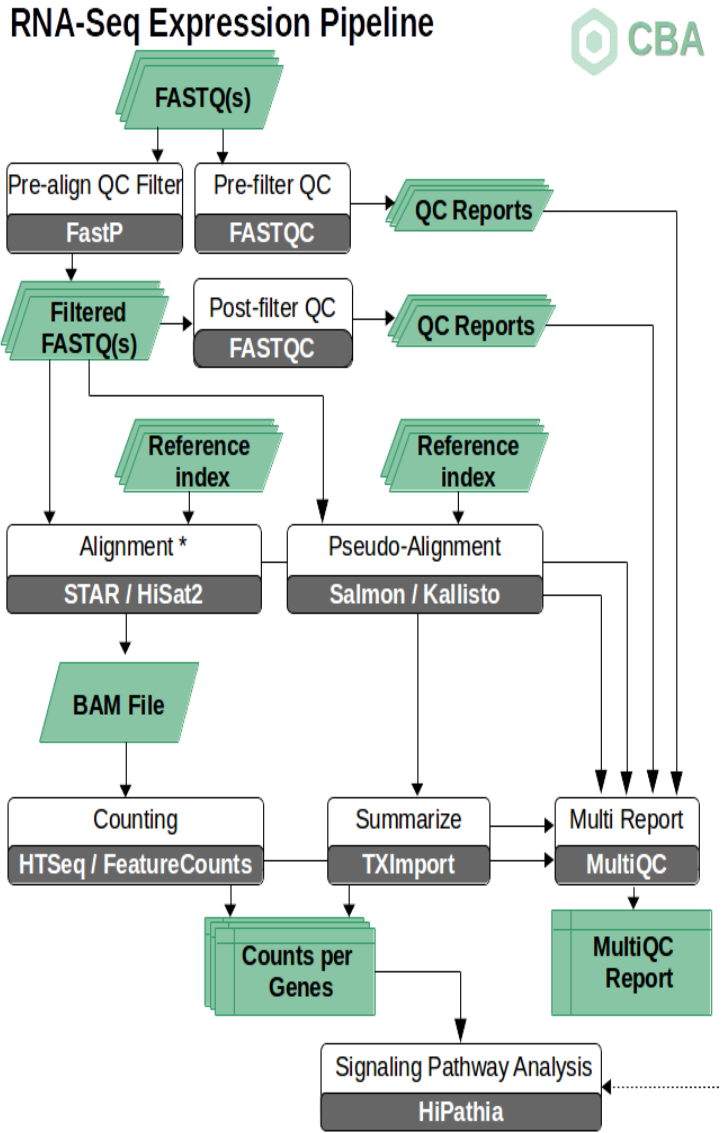

#### All codes written here are in bash. If you're working on windows, you can get a bash prompt by getting an Ubuntu environment using WSL (windows subsystem for linux; this is what I'm doing). Or you could be working on the server which also runs on bash, but preferably the former. If you don't have either of this set up yet, do it before following this vignette.

# Step 1: Set up working directory 

#### We want four empty directories inside a main directory, as follows:
    +-- Yin 
        +-- data 
        +-- quants 
        +-- references
        +-- multiqc

#### set working directory in bash
    cd Yin

# Step 2: Download/install required software/files

### Install and set up sra-tools set up sratools following the protocol listed here: https://github.com/ncbi/sra-tools/wiki . Don't try to do this via conda as it will install an outdated version. 
#### Follow steps 02, 03, and 05. Rest (e.g. cloud credentials) aren't needed for our purposes 

### Install salmon, fastp, MultiQC via conda. Simply: 
    conda install -c bioconda fastp
    conda install bioconda::salmon
    conda install multiqc 

### and download the latest mouse transcriptome from ensembl to /references (in Step 1)

# Step 3: Download FASTQs using SRA toolkit

#### Prefetch the four FASTQs in /data
    cd data 
    vdb-config --prefetch-to-cwd 
    prefetch SRR24860167 --max-size 420000000000 
    prefetch SRR24860168 --max-size 420000000000 
    prefetch SRR24860169 --max-size 420000000000 
    prefetch SRR24860170 --max-size 420000000000 

#### Still in /data, fasterq-dump (get the FASTQs). We are using --split-files because this is paired end reads
    fasterq-dump SRR24860167 --split-files 
    fasterq-dump SRR24860168 --split-files 
    fasterq-dump SRR24860169 --split-files 
    fasterq-dump SRR24860170 --split-files 

#### Your /data directory should now have four SRR directories containing the .sra files and two fastq files per SRR in the format SRRXXX_1.fastq and SRRXXX_2.fastq. We are only interested in the FASTQs so we can delete the sra file-containing directories if needed. 
    rm -r SRR24860167 SRR24860168 SRR24860169 SRR24860170

#### Optionally gzip all FASTQs to (drastically) save disc space 
    gzip *.fastq

# Step 4: QC and trim FASTQs using fastp

#### fastp conveniently generates a QC report as well as trims the FASTQs for us. 
#### Still in /data 
    for sample in SRR24860167 SRR24860168 SRR24860169 SRR24860170
    do
      fastp \
        -i "${sample}_1.fastq.gz" \
        -I "${sample}_2.fastq.gz" \
        -o "${sample}_1.trim.fastq.gz" \
        -O "${sample}_2.trim.fastq.gz" \
        -h "${sample}_fastp.html" \
        -j "${sample}_fastp.json" \
        -w 8 \
        --detect_adapter_for_pe \
        --trim_poly_g \
        --trim_poly_x \
        --length_required 20
    done

#### In your /data, you should now have the raw FASTQs, trimmed FASTQs, and quality reports
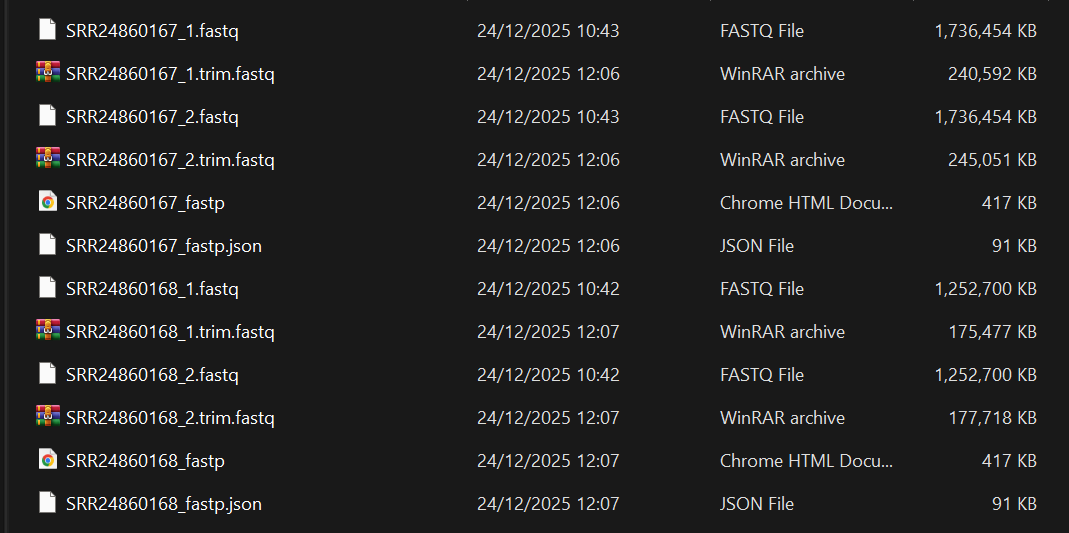
#### etc...

# Step 5: Quantification using salmon

#### First, set working directory to /references and build an index using the ensembl transcriptome downloaded in Step 2, remember this should be in /references. An index is a file format needed for quantification using salmon. 
    cd ..
    cd references 
    salmon index -t Mus_musculus.GRCm39.cdna.all.fa.gz -i mouse_index_k23 -k 23
#### This should create a directory /mouse_index_k23 in /references, which contains our index. 
#### -k 23 is needed because k<=read length, which is 25 in our case. Replace Mus_musculus.GRCm39.cdna.all.fa with whatever the name of your transcriptome file is. 
#### We can then quantify our FASTQs to make salmon quantification output files 
    cd ..
    for sample in SRR24860167 SRR24860168 SRR24860169 SRR24860170
    do
    salmon quant -i references/mouse_index_k23 -l A \
        -1 data/${sample}_1.trim.fastq.gz \
        -2 data/${sample}_2.trim.fastq.gz \
        -p 8 --validateMappings -o quants/${sample}_quant
    done

#### We should now have four directories within /quants for each sample. Each directory contains the quant.sf file that we need. 
    +-- quants 
        +-- SRR24860167_quant 
            +-- quant.sf 
            ...
        ...

# Step 6: MultiQC report 

#### fastp quality controls individual samples, MultiQC looks at all the samples we processed and gives us an overall report of our data. Doing this is really simple, as multiqc automatically searches for all the reports (in our case from salmon and fastp) in our current working directory. Simply set working directory to /Yin and run multiqc
    multiqc .
#### This creates a folder multiqc_data and a readable HTML report multiqc_report. You might want to move these to a separate directly /multiqc for organisation 
    mv multiqc_data multiqc_report.html multiqc 

#### Upon opening multiqc_report.html, you should see something like this: 
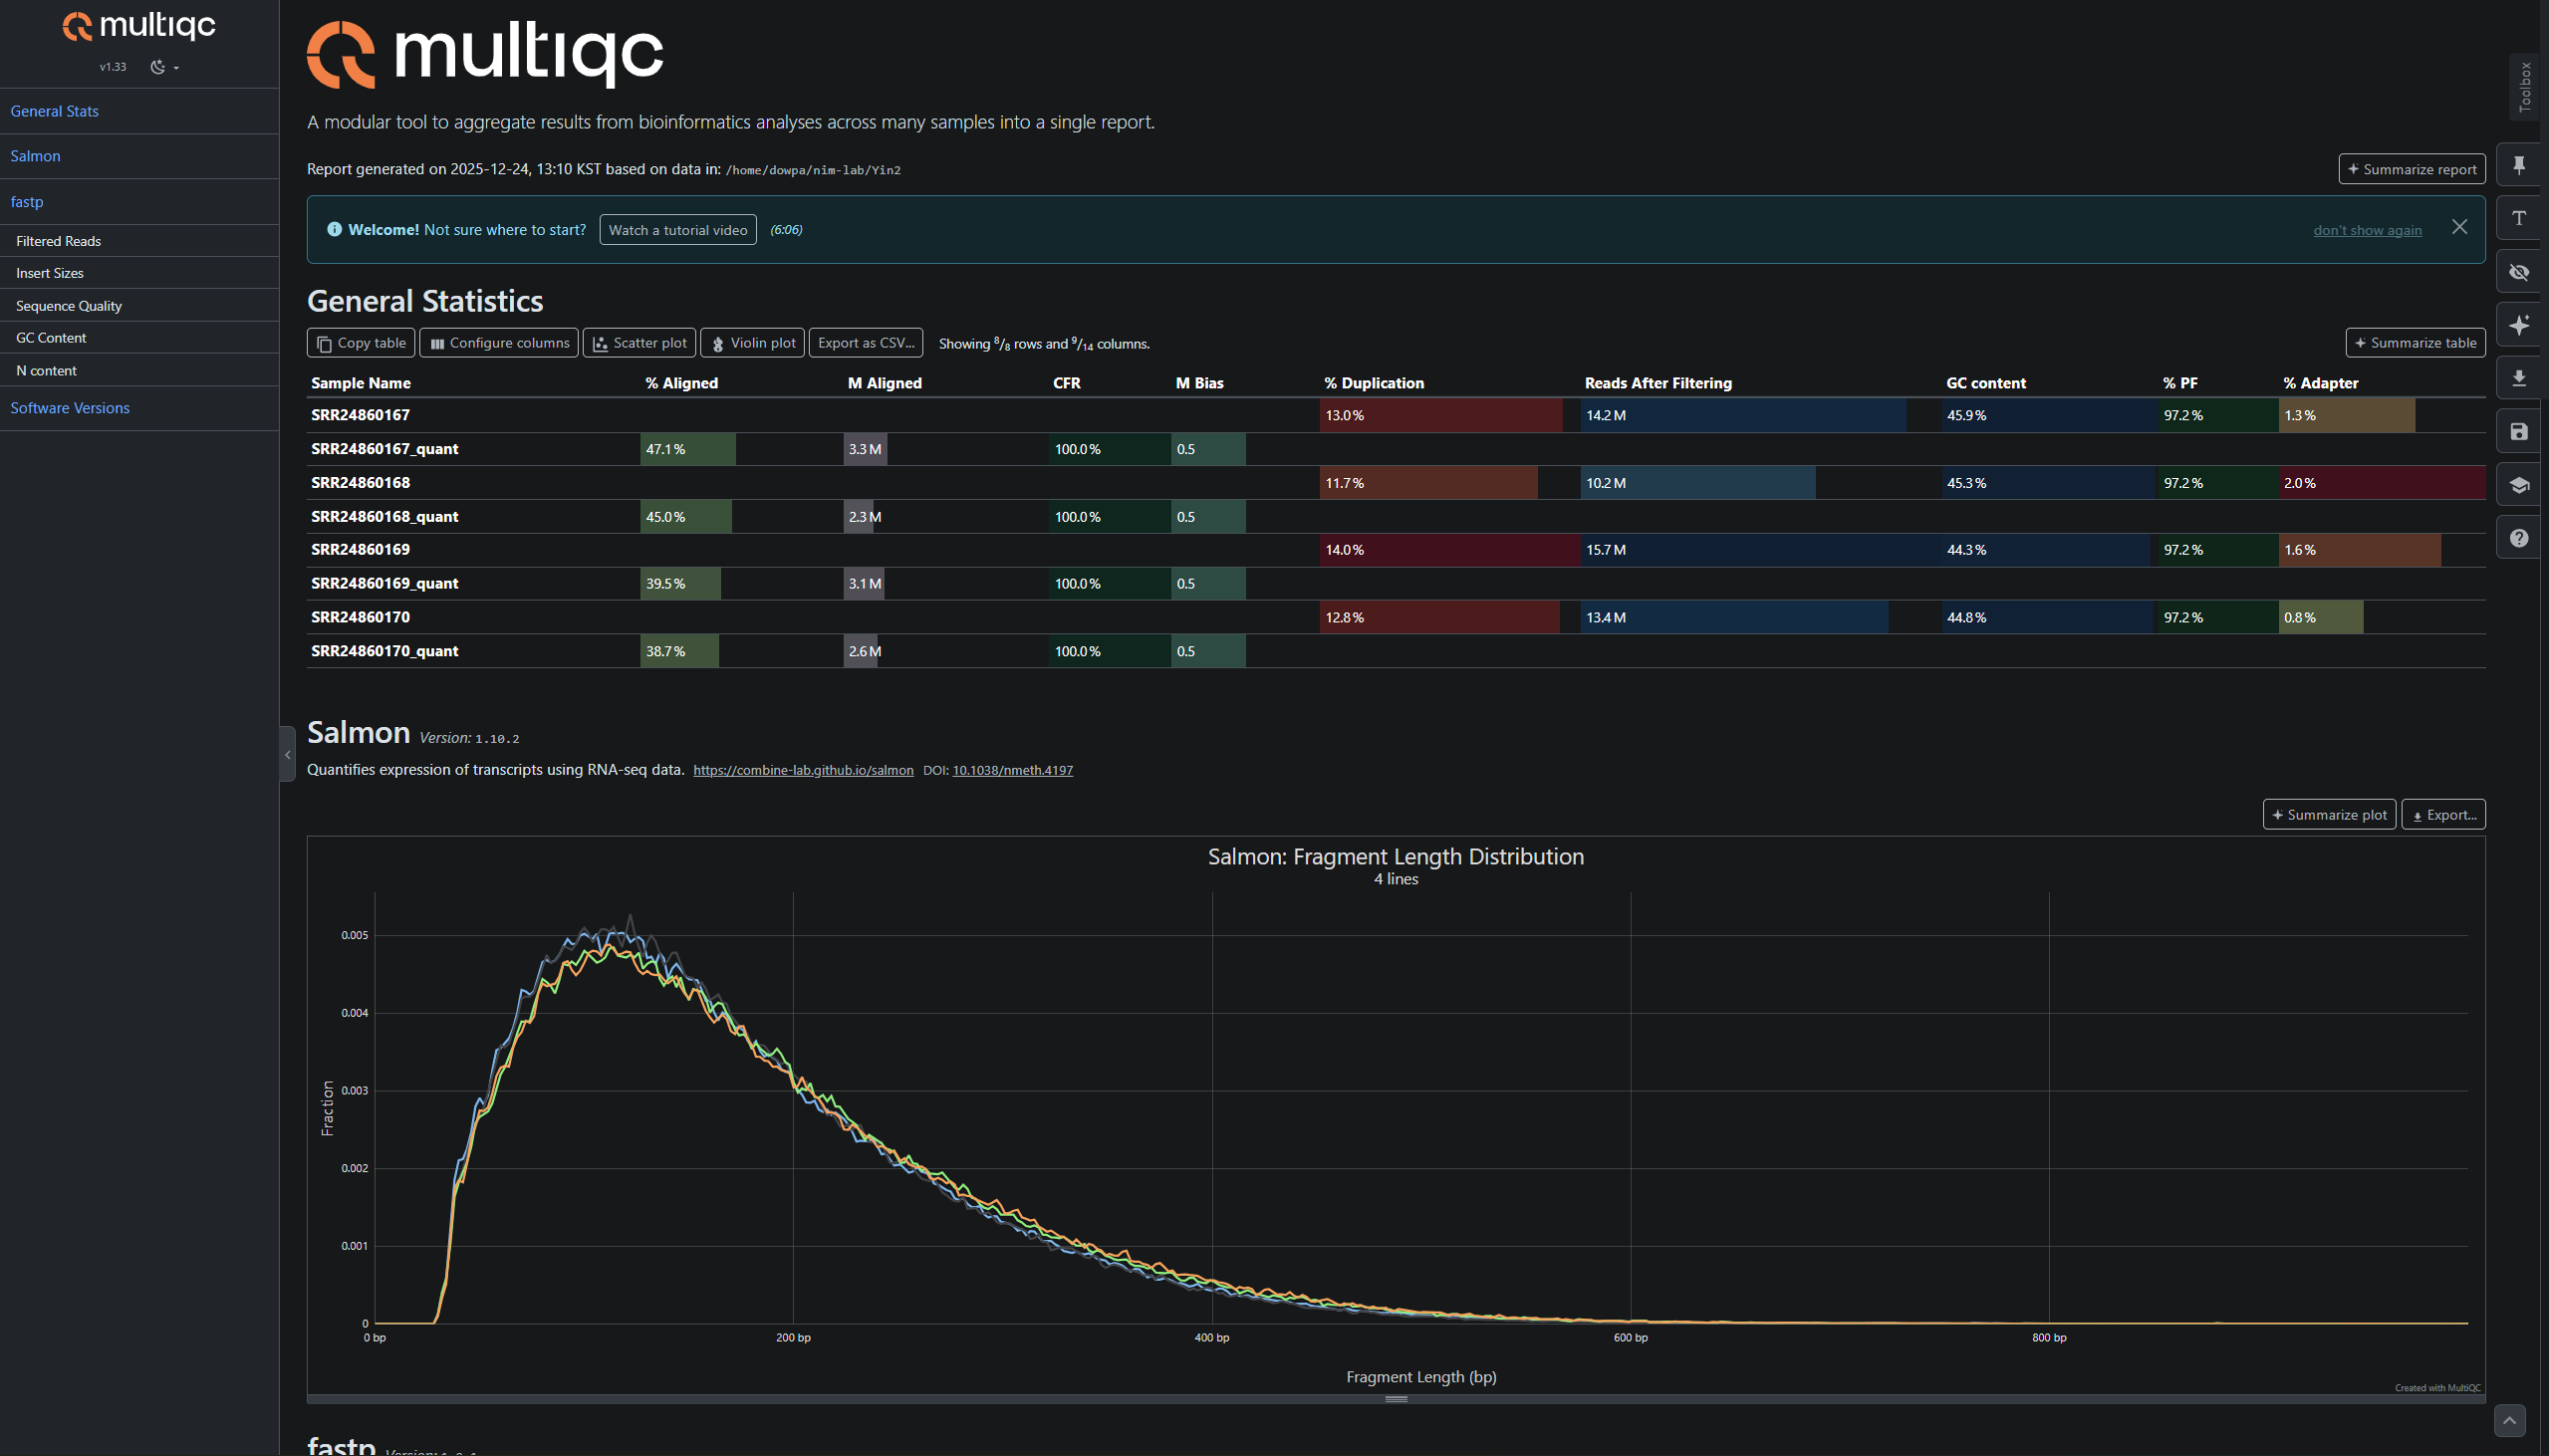
#### You paste this screenshot at the end to chatgpt and ask if it looks fine. If it says yes, great! 
#### We can now move to R 